## Regression Analysis

### Load the libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
import warnings 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Linear regression 
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Regularization - Ridge and Lasso regression (linear regressions)
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV

# Polynomial regression
from sklearn.preprocessing import PolynomialFeatures

# Other non-linear regression (and tuning mechanism)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Regression metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

warnings.simplefilter(action='ignore', category=FutureWarning)

# Set parameters like font sizes for all plots 
sns.set_context("paper", rc={"font.size":15,
                             "axes.titlesize":15,
                             "axes.labelsize":15})  
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%matplotlib inline

### Load the data

Have you ever asked yourself, how are diamonds priced? 

<img src="img/diamonds.jpeg" width=300 height=300 />

This tutorial handles the diamonds' price prediction based on their cut, colour, clarity & other attributes. The classic [Diamonds](https://www.kaggle.com/datasets/shivam2503/diamonds) dataset contains the prices and other attributes of almost 54,000 diamonds (53,940 rows and 10 variables). Before jumping into building the model, let’s have a look into the variables & their definitions: 

- *price*: price in US dollars (326 -- 18,823)
- *carat*: weight of the diamond (0.2--5.01)
- *cut*: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- *color*: diamond colour, from J (worst) to D (best)
- *clarity*: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- *x*: length in mm (0--10.74)
- *y*: width in mm (0--58.9)
- *z*: depth in mm (0--31.8)
- *depth*: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- *table*: width of top of diamond relative to widest point (43--95)

In [2]:
# Import the diamonds.csv dataset into a new variable named "diamonds"
# Print the shape and preview the first rows 

diamonds = pd.read_csv('data/diamonds.csv')
print(diamonds.shape)
diamonds.head()

(53940, 11)


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


#### Data cleaning - Drop any unecessary features and duplicates

In [3]:
# Drop (in place or assign back to "diamonds") any unecessary features 

diamonds.drop('Unnamed: 0', inplace=True, axis=1)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
# Remove/drop all the duplicates inplace(=True) or assign back to "diamonds"

diamonds.drop_duplicates(inplace=True)
diamonds.shape

(53794, 10)

### Check for null values

In [5]:
# Check for null values using .info(), isnull().any() or any other way

diamonds.info()
diamonds.isnull().any()

print(diamonds.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 53794 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53794 non-null  float64
 1   cut      53794 non-null  object 
 2   color    53794 non-null  object 
 3   clarity  53794 non-null  object 
 4   depth    53794 non-null  float64
 5   table    53794 non-null  float64
 6   price    53794 non-null  int64  
 7   x        53794 non-null  float64
 8   y        53794 non-null  float64
 9   z        53794 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


In [6]:
# Print the sum of the null values per column 

print(diamonds.isnull().sum())

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


### EDA 

As a reminder, there are two methods to analyze the data correlation in Multiple Linear Regression, those are Univariate Analysis and Multivariate Analysis.

#### a) Univariate Analysis

Univariate Analysis is the simplest form of analyzing data. “Uni” means “one”, so in other words, your data has only one variable. It takes data, summarizes that data and finds patterns in the data. In simple form, we check the summary statistics for each column in the data set (or) summary only on one variable.

#### b) Multivariate Analysis

Multivariate Analysis takes a whole host of variables into consideration. This makes it a complicated as well as an essential tool. The greatest virtue of such a model is that it considers as many factors into consideration as possible. This results in a tremendous reduction of bias and gives a result closest to reality. In simple form, Multivariate Analysis is used for understanding the interactions between each field in the dataset more than two.

##### Dependent (target) variable: visualize the distribution of the target variable 

Distribution plots are very useful to check how well a variable is distributed in the dataset. Use the univariate plot (one variable at a time) `distplot` to check the distribution of the 'price', which is our target variable: 

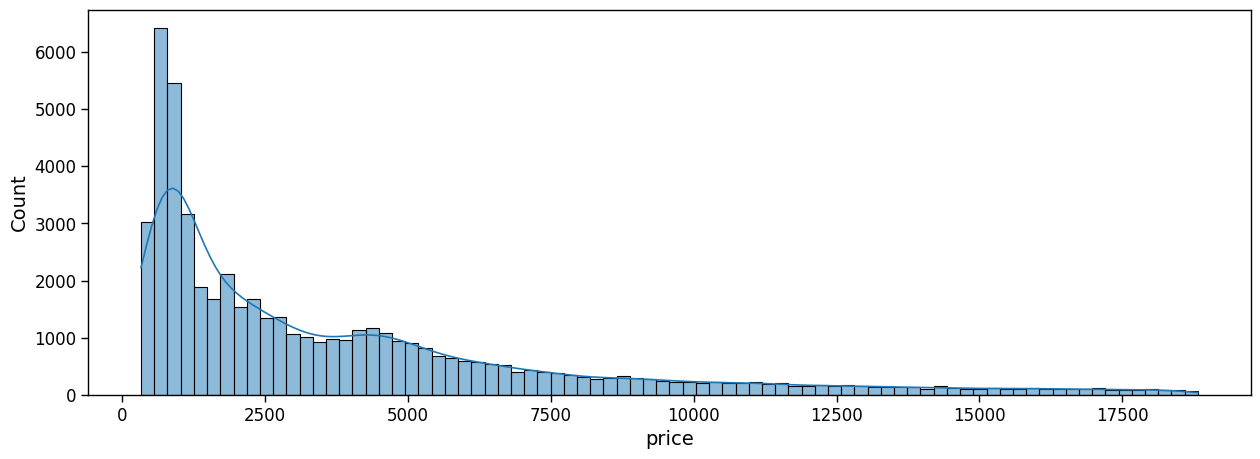

In [7]:
# Plot a seaborn histplot of the price data from "diamonds". Set kde=True

plt.figure(figsize=(15, 5))
sns.histplot(data=diamonds, x="price", kde=True)
plt.show()

- *What do you notice?*

**Skewness** is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point. **Kurtosis** is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.

In [8]:
# 1) Print the skewness: Apply on the column diamonds['price'] the function .skew() 
# 2) print the kurtosis: Apply on the column diamonds['price'] the function .kurt()  

print("Skewness: %f" % diamonds['price'].skew())
print("Kurtosis: %f" % diamonds['price'].kurt())

Skewness: 1.618240
Kurtosis: 2.178453


##### Independent variables: check the statistical properties of the numerical features 

In [9]:
# Get the statistical properties of the numerical features in "diamonds"

diamonds.describe()

,carat,depth,table,price,x,y,z
count,53794.00000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000
mean,0.79778,61.748080,57.458109,3933.065082,5.731214,5.734653,3.538714
std,0.47339,1.429909,2.233679,3988.114460,1.120695,1.141209,0.705037
min,0.20000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.40000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,5326.750000,6.540000,6.540000,4.030000
max,5.01000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


- *What do you observe when checking the minimum values?* 

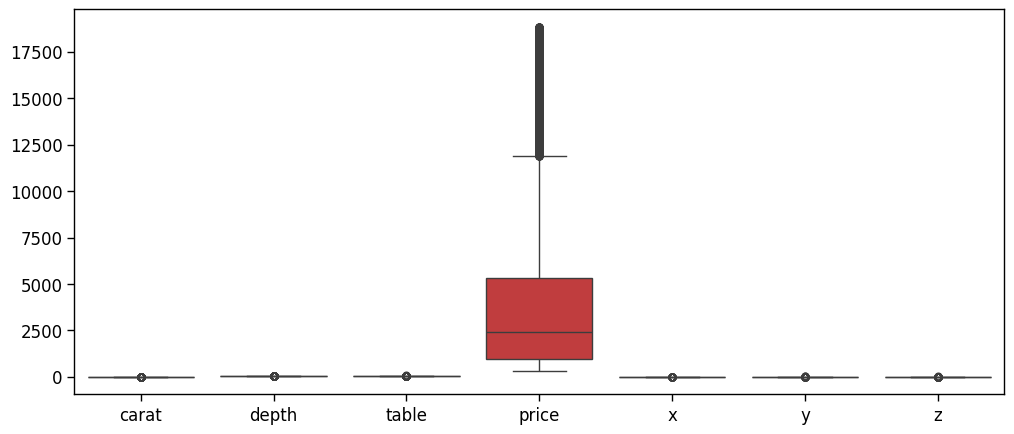

In [10]:
# Visualize the statistical properties of the numerical features in "diamonds" using a boxplot 

plt.figure(figsize=(12, 5))
sns.boxplot(data=diamonds)
plt.show();

#### Scatterplot - Investigate a 2D relationship between features (incl. target variable)

##### Price and carat relationship

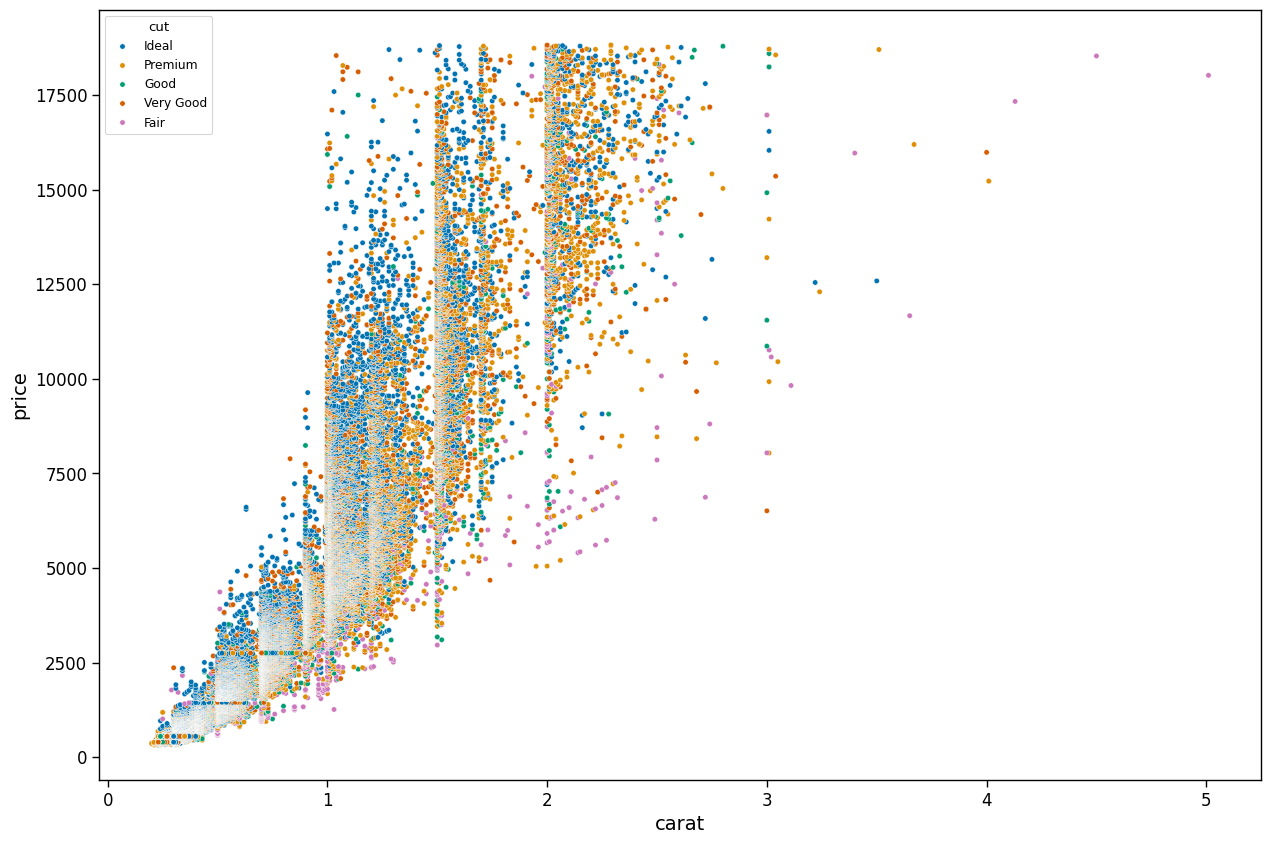

In [11]:
# Visualize a 2D scatterplot of "carat" vs. "price" from the "diamonds" data. Use the "cut" as the 'hue'. 
# optional: set the size point size equal to "s=15" in the scatterplot

plt.figure(figsize=(15, 10))
sns.scatterplot(x='carat', y='price', data=diamonds, hue='cut', palette='colorblind', s=15)
plt.show()

The plot shows a fairly strong positive relationship between carat and price.

#### Relationship between variables 
##### Pairplot 

Let's look at the pair plot of the dataset. Pair plot allows us to see both the *distribution of variables* and also the *relationships between two variables*

<Figure size 3000x1500 with 0 Axes>

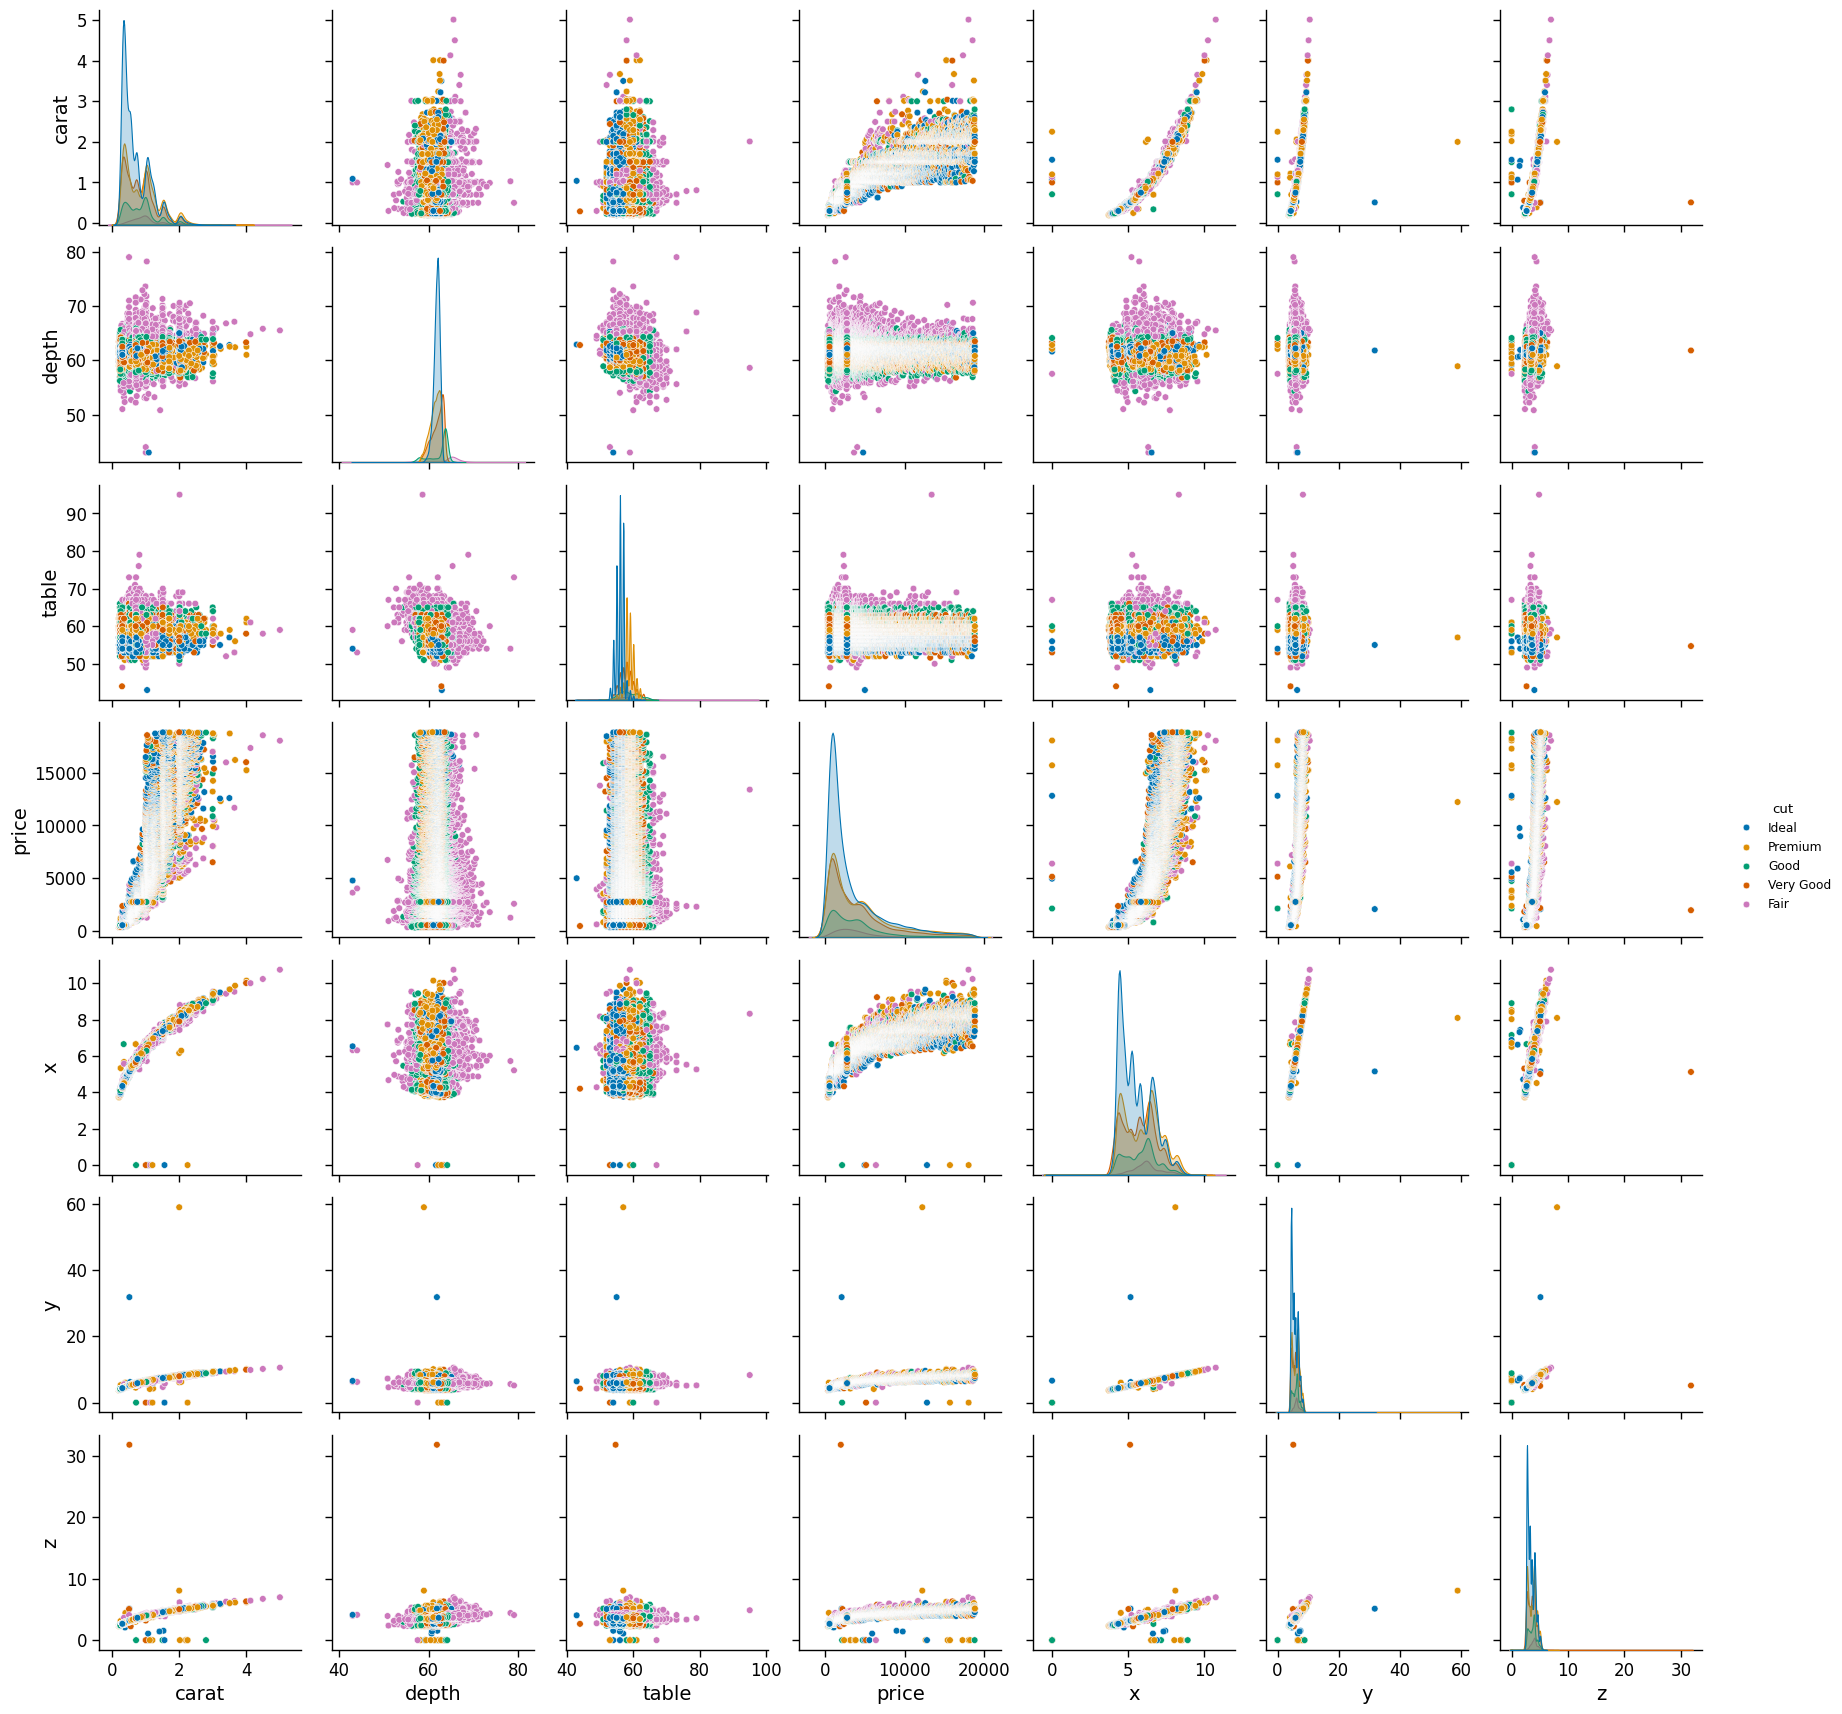

In [12]:
# Visualize a pairplot of all the variables against each other. Use the "cut" as the pairplot's 'hue'. 
# Set the figure size to (30, 15)
# This plot may take a while to execute! 

plt.figure(figsize=(30, 15))
sns.pairplot(data=diamonds, hue='cut', palette='colorblind')
plt.show();

##### Correlation heatmap 

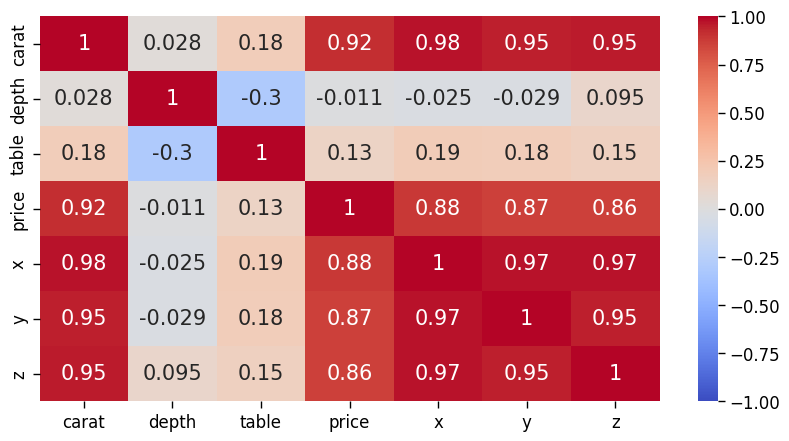

In [13]:
# Get the Pearson correlations and plot the correlation coefficient heatmap 

plt.figure(figsize=(10, 5))
sns.heatmap(diamonds.corr(numeric_only=True), 
            vmin=-1, 
            vmax=1, 
            cmap="coolwarm", 
            annot=True)
plt.show()

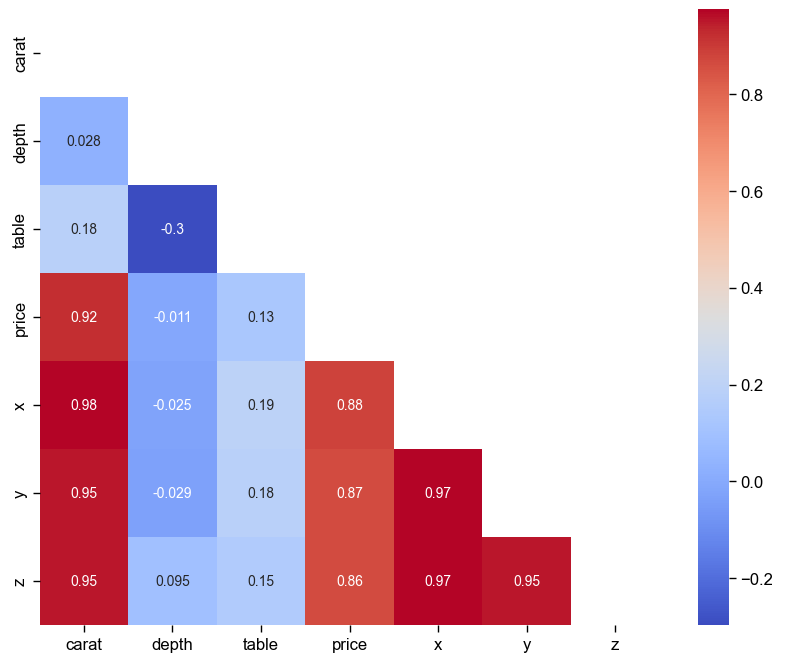

In [14]:
# Heatmap alternative display

# We need to create a mask which will be used as a filter (creates an array of zeros)
zero = np.zeros_like(diamonds.corr(numeric_only=True))
triangle_indices = np.triu_indices_from(zero)
zero[triangle_indices] = True

# Check the relationship between all the features with the target 
plt.figure(figsize=(10, 8))
sns.heatmap(diamonds.corr(numeric_only=True), 
            mask=zero, 
            cmap="coolwarm", 
            annot=True, 
            annot_kws={'size': 10})

sns.set_style('whitegrid')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()     

### Data mining (extra steps - filtering and feature removal, feature engineering, etc) 

#### Apply filter 

Observed that the minimum value of x (length), y(width) & z(depth) is zero. this indicates that there are faulty values in data that represents dimensionless or 2-dimensional diamonds. So we need to filter out those as it clearly faulty data points. 

In [15]:
# Dropping dimentionless diamonds -- exclude/filter any rows where x=0, y=0 AND z=0
# Print the shape of the data after the filter 
# THERE ARE VARIOUS WAYS YOU CAN PERFORM THIS STEP

diamonds = diamonds.drop(diamonds[diamonds["x"]==0].index)
diamonds = diamonds.drop(diamonds[diamonds["y"]==0].index)
diamonds = diamonds.drop(diamonds[diamonds["z"]==0].index)

# Alternatively 
# diamonds = diamonds.loc[(diamonds[['x','y','z']]!=0).all(axis=1)]

diamonds.shape

(53775, 10)

In [16]:
# Sanity check: confirm that there won't be any zero values rows 
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53775.000000,53775.000000,53775.000000,53775.000000,53775.000000,53775.000000,53775.000000
mean,0.797536,61.748232,57.457806,3931.220288,5.731579,5.734909,3.539964
std,0.473169,1.429639,2.233257,3985.918716,1.118611,1.139451,0.702017
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.000000,6.540000,6.540000,4.030000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


#### Feature Engineering (optional - more advanced step) 

After familiarization with the business domain, you could proceed and engineer a few additional new features: 

In [17]:
# Create a new feature "volume" in the "diamonds" dataframe based on the multiplication of features x, y and z
# Preview once more the diamonds first few rows 

diamonds['volume'] = diamonds.x * diamonds.y * diamonds.z
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,volume
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.202030
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,46.724580
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.917250


In [18]:
# Remember to drop the features x, y and z to avoid additional correlations and repeated info 
# Perform inplace=True or assign back to diamonds 

diamonds.drop(['x','y','z'], axis=1, inplace=True)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,volume
0,0.23,Ideal,E,SI2,61.5,55.0,326,38.202030
1,0.21,Premium,E,SI1,59.8,61.0,326,34.505856
2,0.23,Good,E,VS1,56.9,65.0,327,38.076885
3,0.29,Premium,I,VS2,62.4,58.0,334,46.724580
4,0.31,Good,J,SI2,63.3,58.0,335,51.917250


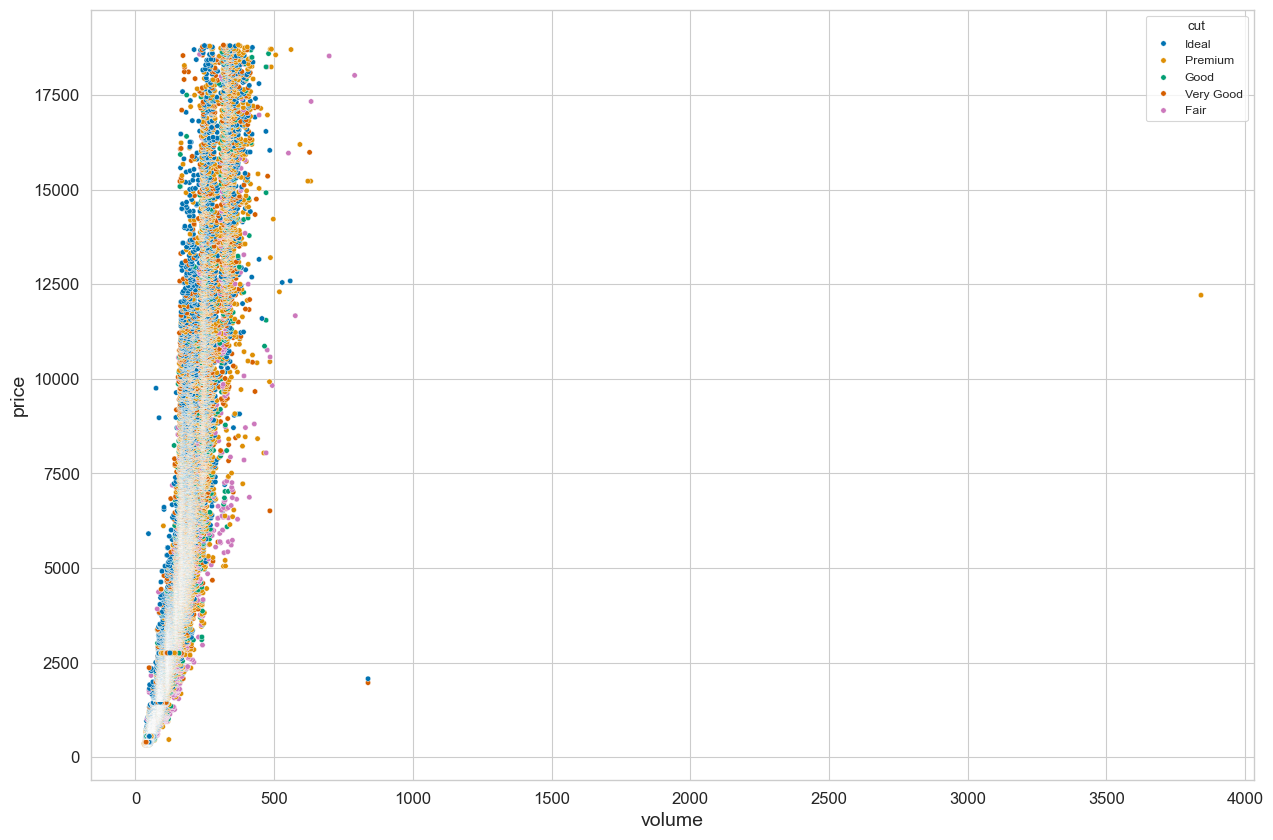

In [19]:
# Plot the relationship between volume and price using a 2D scatterplot. Use hue='cut'

plt.figure(figsize=(15, 10))
sns.scatterplot(x='volume', y='price', data=diamonds, hue='cut', palette='colorblind', s=15)
plt.show()

### Independent Variables & Dependent Variables

At this stage, we can proceed and split our input data into our feature matrix of independent variables `X` and dependent variable `y` (that will hold the numeric value to be predicted; in this case, 'price') 

In [20]:
# Spit the data into X and y (what is your y in this case?)
# Preview the first few rows of your y using head()

X = diamonds.drop('price', axis=1)
y = diamonds['price'] 
y.head()

0    326
1    326
2    327
3    334
4    335
Name: price, dtype: int64

### Train / test split

As with classification, we need to split the data into training and testing sets using `train_test_split` function to ensure good generalization performance. The `test_size` parameter specifies the proportion of the data that should be used for testing, and the `random_state` parameter is used to ensure that the same split is obtained each time the program is run. Note: `stratify` obviously *cannot* be applied here

In [21]:
# Split the X and y data into train and test sets using a 80/20 split. Set the random_state=0 
# Note: stratify obviously cannot be applied here

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state=0)

In [22]:
# Print the shapes of X_train, X_test, y_train, y_test

print('Shape of x_train and y_train: ', X_train.shape, y_train.shape)
print('Shape of x_test and y_test: ',   X_test.shape,  y_test.shape)

Shape of x_train and y_train:  (43020, 7) (43020,)
Shape of x_test and y_test:  (10755, 7) (10755,)


### Encoding categorical variables 

As we've previously learned, one of the simplest ways to convert our categorical to numerical variables is to apply one hot encoding (`pd.get_dummies`).

In [23]:
# Easy and simplistic option: we can use get_dummies from pandas 
# or OneHotEncoder from sklearn to perform one hot encoding (0s and 1s)

# X_train = pd.get_dummies(X_train)
# X_test  = pd.get_dummies(X_test)

Alternatively, **if you possess or can infer (from EDA) some practical, domain knowledge,** you can map these features in a different way (always with caution and common sense!). 

Note: the higher the value, the higher the importance in the model building process. For example, 'Ideal' is mapped as 5 because its quality is higher than Fair, which is mapped as 1. Therefore, we notice that there is a sense of ranking. 

In [24]:
# Replace the values with some numerical values that may look appropriate 
# (business-wise) for this particular use case 

X_train.cut.replace({'Ideal':5, 'Premium':4, 'Good':2, 'Very Good':3, 'Fair':1}, inplace=True)
X_test.cut.replace({'Ideal':5, 'Premium':4, 'Good':2, 'Very Good':3, 'Fair':1},  inplace=True)

X_train.color.replace({'E':2, 'I':6, 'J':7, 'H':5, 'F':3, 'G':4, 'D':1}, inplace=True)
X_test.color.replace({'E':2, 'I':6, 'J':7, 'H':5, 'F':3, 'G':4, 'D':1}, inplace=True)

X_train.clarity.replace({'SI2':1, 'SI1':2, 'VS1':3, 'VS2':4, 'VVS2':5, 'VVS1':6, 'I1':7, 'IF':8}, inplace=True)
X_test.clarity.replace({'SI2':1, 'SI1':2, 'VS1':3, 'VS2':4, 'VVS2':5, 'VVS1':6, 'I1':7, 'IF':8}, inplace=True)

In [25]:
# Sanity check: preview once more the X_train data to screen the mappings

X_train.head()

,carat,cut,color,clarity,depth,table,volume
22478,1.51,5,5,2,62.8,55.0,244.935252
42627,0.32,3,5,4,62.3,57.0,52.373139
13838,1.09,4,2,2,62.5,57.0,177.944505
45564,0.52,5,4,3,62.3,55.0,85.136904
18159,1.31,4,4,2,62.2,56.0,212.842890


### Scaling 

As with other Machine Learning models (classification, clustering), Regression also needs the features to be scaled appropriately prior to model fitting.

In [26]:
# 1) Instantiate the StandardScaler() or MinMaxScaler() from sklearn and store into a variable named "scaler" 
# 2) Fit the scaler ONLY on the training data (and transform - this could be done using two separate steps/functions)
# Also, cast into a pandas DataFrame with the columns info from Xtrain
# 3) Use the fitted scaler to transform the test data 
# Also, cast into a pandas DataFrame with the columns info from X_test

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [27]:
# Sanity check: print the shapes of X_train, y_train, X_test and y_test

print('Shape of x_train and y_train: ', X_train.shape, y_train.shape)
print('Shape of x_test and y_test: ',   X_test.shape,  y_test.shape)

Shape of x_train and y_train:  (43020, 7) (43020,)
Shape of x_test and y_test:  (10755, 7) (10755,)


In [28]:
# Sanity check: preview once more the X_train data to screen the scaling effect
X_train.head()

,carat,cut,color,clarity,depth,table,volume
0,1.505838,0.982135,0.824265,-0.711772,0.736935,-1.103438,1.464003
1,-1.011104,-0.811068,0.824265,0.421961,0.386164,-0.205843,-0.988377
2,0.617505,0.085534,-0.939967,-0.711772,0.526473,-0.205843,0.610840
3,-0.588089,0.982135,0.236188,-0.144905,0.386164,-1.103438,-0.571113
4,1.082822,0.085534,0.236188,-0.711772,0.316010,-0.654641,1.055290


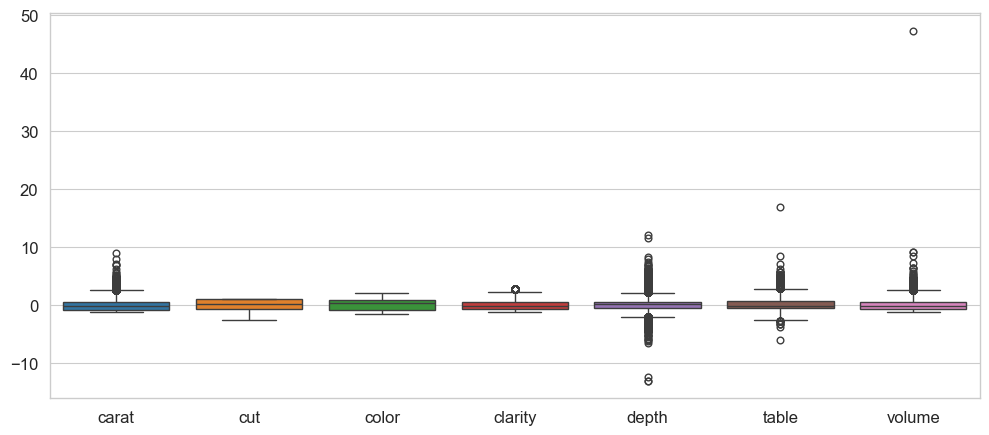

In [29]:
# Optional: plot the scaled X_train in a boxplot

plt.figure(figsize=(12, 5))
sns.boxplot(data=X_train)
plt.show();

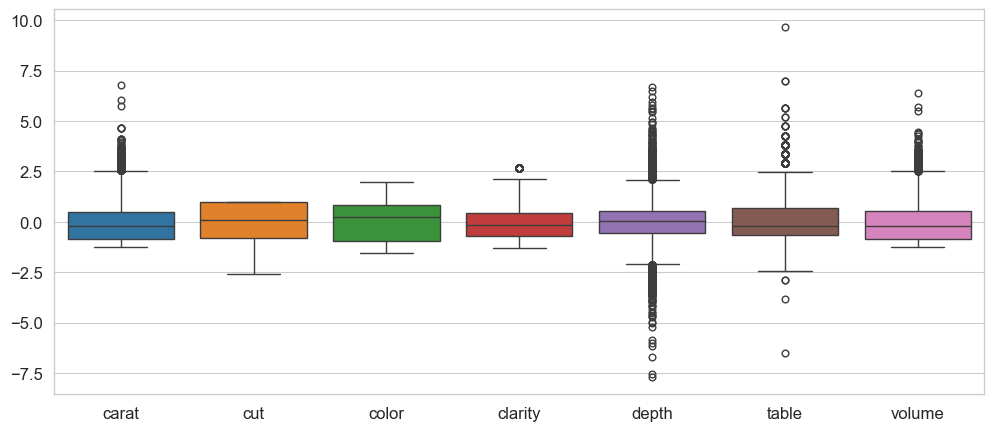

In [30]:
# Optional: plot the scaled X_test in a boxplot
plt.figure(figsize=(12, 5))
sns.boxplot(data=X_test)
plt.show();

## Prediction - Regressors 



In [31]:
# Create an empty DataFrame named 'regr_results' to store and compare evaluation results from the various regressors
# Use the Titanic dataset as inspiration 

regr_results = pd.DataFrame([])

### Multiple linear regression

In [32]:
# 1) Instantiate the LinearRegression() model from sklearn. Store it into a new variable "linear_regr" 
# 2) Fit linear_regr to your training data  
# 3) Predict using only the test set and store the results into a new variable y_pred

linear_regr = LinearRegression()
linear_regr.fit(X_train, y_train)
y_pred = linear_regr.predict(X_test)

As a next step, you can return the performance metrics of the test set. 


Note: When you’re applying `.score()`, the arguments are also the predictor x and response y, and the return value is 𝑅².

In [33]:
# 4) Print the regression (prediction/evaluation) test metrics R^2, RMSE and MAE 

# You can obtain the coefficient of determination, 𝑅², with .score() called on model: 
# r2 = round(linear_regr.score(X_test, y_test), 3)
# Or alternatively r2 = round(r2_score(y_test, y_pred),3)


# Print the R^2 
# Print the RMSE 
# Print the MAE
print('r2 score (coefficient of determination): '+str(round(r2_score(y_test, y_pred),3)))
print('RMSE : '+str(round(np.sqrt(mean_squared_error(y_test, y_pred)),3)))  
print('MAE : ' +str(round(mean_absolute_error(y_test, y_pred),3)))

r2 score (coefficient of determination): 0.883
RMSE : 1372.015
MAE : 883.58


In [34]:
# Print the predicted values (y_pred) to get a sense of the predicted values 

print(y_pred)

[1305.43328068 1018.90657947 1263.57551706 ...  -42.75888099   66.76418444
 1511.09189071]


In [35]:
# Optional: create a new DataFrame named 'comparison' where you can combine/compare the actual and predicted values
# Create a new column 'y_actual' and set its values to the ones contained in y_test 
# and another new column 'y_predicted' and set its values to the ones in y_pred
# Preview its results

comparison = pd.DataFrame([])
comparison['y_actual'] = y_test
comparison['y_predicted'] = y_pred
comparison.head()

,y_actual,y_predicted
43374,1409,1305.433281
33116,816,1018.906579
37564,988,1263.575517
19830,8398,6840.200384
29735,708,591.633761


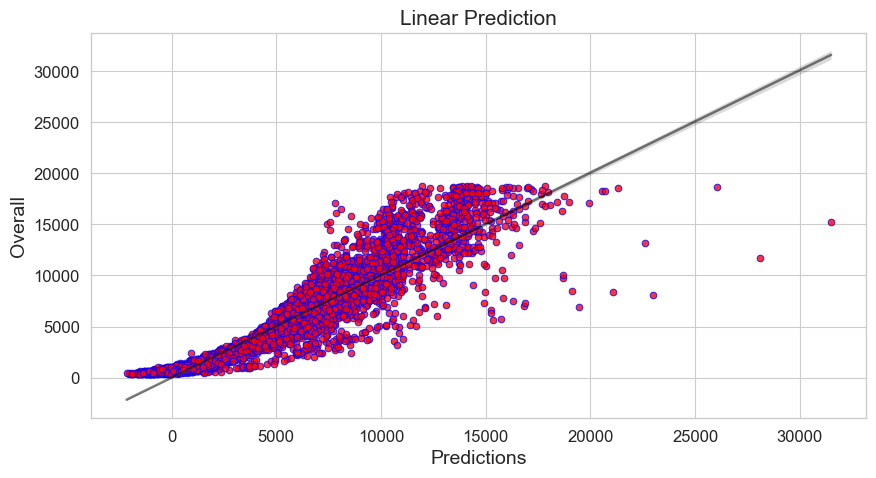

In [36]:
# Visualising the results in a regplot between y_pred and y_test. 
# Pass as additional arguments 
# scatter_kws={'color':'red','edgecolor':'blue', 'linewidths':0.7} 
# and line_kws={'color':'black','alpha':0.5}

plt.figure(figsize=(10,5))
sns.regplot(x= y_pred, y = y_test, 
            scatter_kws={'color':'red',
                         'edgecolor':'blue',
                         'linewidths':0.7},
            line_kws={'color':'black','alpha':0.5}
           )
plt.xlabel('Predictions')
plt.ylabel('Overall')
plt.title("Linear Prediction")
plt.show()

In [37]:
# Store the model performances in regr_results for the final comparison 
# Feature the Model name/type, r2 (round to 3 decimals), RMSE (round to 3 decimals), MAE (round to 3 decimals)
# Preview the results 

# Use as inspiration the example from the Titanic dataset 

regr_results = pd.concat([regr_results, pd.json_normalize({'Model': 'Linear model (OLS)',
                                                           'r2':   round(r2_score(y_test, y_pred),3), 
                                                           'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred)),3),
                                                           'MAE':  round(mean_absolute_error(y_test, y_pred),3)})])

regr_results

,Model,r2,RMSE,MAE
0,Linear model (OLS),0.883,1372.015,883.58


##### Slope and Intercept 

The attributes of the linear model are `.intercept_`, which represents the coefficient 𝑏₀, and `.coef_`. You can notice that `.intercept_` is a scalar, while `.coef_` is an array.

In [38]:
# Print the slope using the linear_regr model's returned parameter .coef_ 
# Similarly, print the intercept using linear_regr model's .intercept_

print('Slope: ' ,     linear_regr.coef_)
print('\nIntercept:', linear_regr.intercept_)

Slope:  [3920.81766834  176.50659669 -486.19021376  540.13250469 -112.05233643
  -91.36503266   83.94327479]

Intercept: 3933.0762203626223


In [39]:
# Optional: combine together the coefficient and their corresponding variable names in a new DF named 'coef'

coef = pd.DataFrame({'Columns':X_train.columns,
                     'Coefficient Estimate':pd.Series(linear_regr.coef_)
                    })
coef.head(10)

,Columns,Coefficient Estimate
0,carat,3920.817668
1,cut,176.506597
2,color,-486.190214
3,clarity,540.132505
4,depth,-112.052336
5,table,-91.365033
6,volume,83.943275


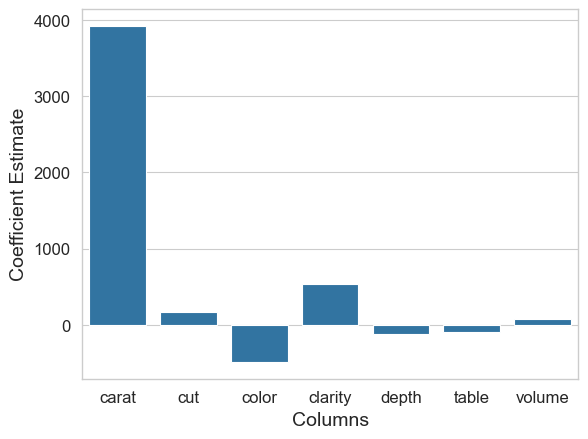

In [40]:
# Create a seaborn barplot of the coef 

sns.barplot(data=coef, x='Columns', y='Coefficient Estimate')
plt.show()

##### (EXTRA) information using statsmodels.api  

We can also use Python’s statsmodels module to implement Ordinary Least Squares(OLS) method of linear regression. The `OLS()` function of the `statsmodels.api` module is used to perform OLS regression. It returns an OLS object. Then `fit()` method is called on this object for fitting the regression line to the data. The `summary()` method is used to obtain a table which gives an extensive description about the regression results

In [41]:
import statsmodels.api as sm

# statsmodels needs y as a numpy array so we need to convert 
y_train_array = np.array(y_train)
X_train_const = sm.add_constant(X_train)

ols_model = sm.OLS(y_train_array, X_train_const)
results = ols_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                 4.585e+04
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:18:51   Log-Likelihood:            -3.7168e+05
No. Observations:               43020   AIC:                         7.434e+05
Df Residuals:                   43012   BIC:                         7.435e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3933.0762      6.594    596.420      0.0

Description of some of the terms in the table : 
 

- `R-squared` : the coefficient of determination. It is the proportion of the variance in the dependent variable that is predictable/explained
- `Adj. R-squared` : Adjusted R-squared is the modified form of R-squared adjusted for the number of independent variables in the model. Value of adj. R-squared increases, when we include extra variables which actually improve the model.
- `F-statistic` : the ratio of mean squared error of the model to the mean squared error of residuals. It determines the overall significance of the model.
- `coef` : the coefficients of the independent variables and the constant term in the equation.
- `t` : the value of t-statistic. It is the ratio of the difference between the estimated and hypothesized value of a parameter, to the standard error
- `AIC` stands for Akaike Information Criterion, which estimates the relative quality of statistical models for a given dataset.
- `BIC` stands for Bayesian Information Criterion, which is used as a criterion for model selection among a finite set of models. BIC is like AIC, however it adds a higher penalty for models with more parameters.

#### Problems of Linear Regression
Linear Regression a.k.a. Ordinary Least Squares is one of the easiest and most widely used ML algorithms. But it suffers from a fatal flaw — it is super easy for the algorithm to overfit the training data.

### Regularization 

Ridge and Lasso are two of the most important regularization techniques. Both of them solve the problems of **Linear** regression by introducing some bias leading to lower variance and thus avoiding overfitting. The hyperparameter `lambda` controls how severe the regularization is for features with different magnitudes.


#### 1) Regularization with Ridge Regression (L2 regularization)

Let's try first with a pre-defined parameter of `alpha`. The `alpha` is a hyperparameter that controls the regularization strength. It must be a positive float. The default value is 1. Larger values of `alpha` imply stronger regularization (less-overfitting, may be underfitting!). Smaller values imply weak regularization (overfitting). We want to build a model that neither overfits nor underfit the data. So, we need to choose an optimal value for `alpha`. For that, we can use a hyperparameter tuning technique. 

Note: `Ridge(alpha=0)` is equivalent to the normal linear regression solved by the `LinearRegression()` class. **It is not advised to use `alpha=0` with Ridge regression**. Instead, you should use normal linear regression.

In [42]:
# 1) Instantiate a Ridge model with a regularization parameter alpha=0.1. Name your model "ridge_regr"
# 2) Fit it to the training data X_train and y_train using the fit method 
# 3) Predict using the test data and calculate the performance metrics 
# The alpha is a hyperparameter to tune and we need to find out the optimal alpha value

ridge_regr = Ridge(alpha=0.1)
ridge_regr.fit(X_train, y_train)
y_pred = ridge_regr.predict(X_test)

In [43]:
# 4) Print the performance metrics R^2, RMSE and MAE 

print('r2 score (coefficient of determination): '+str(round(r2_score(y_test, y_pred),3)))
print('RMSE : '+str(round(np.sqrt(mean_squared_error(y_test, y_pred)),3)))  
print('MAE : ' +str(round(mean_absolute_error(y_test, y_pred),3)))

r2 score (coefficient of determination): 0.883
RMSE : 1372.014
MAE : 883.578


In [44]:
# Putting together the coefficient and their corresponding variable names in a new DF named 'coef_ridge'

coef_ridge = pd.DataFrame({"var": X_train.columns,
                           "coef":ridge_regr.coef_[0]})
coef_ridge

,var,coef
0,carat,3920.64235
1,cut,3920.64235
2,color,3920.64235
3,clarity,3920.64235
4,depth,3920.64235
5,table,3920.64235
6,volume,3920.64235


##### Ridge Regression: Selecting Optimal Alpha Values Using Cross-Validation in Sklearn

Now, instead of blindly trying out a bunch of values for alpha, we can use cross-validation using RidgeCV. Instead of taking a single value for alpha, RidgeCV takes a list of possible alphas and tries them out using cross-validation, just like GridSearch:

In [45]:
# Execute tuning of alpha using RidgeCV and assign to a variable named "ridgeCV_model". Pass: 
# as alpha the values of np.logspace(-6, 6, 13) 
# as scoring the value 'r2' 
# and set cv equal to 10 for 10-fold cross-validation
# Fit ridgeCV_model to your train data 
# Return the print ridgeCV_model.alpha_ 


ridgeCV_model = RidgeCV(alphas=np.logspace(-6, 6, 13), scoring='r2', cv=10)
ridgeCV_model.fit(X_train, y_train)

optimal_alpha = ridgeCV_model.alpha_
print(optimal_alpha)

1e-06


Let’s finally evaluate a Ridge with that hyperparameter and compare it with Linear Regression:

In [46]:
# Optimal model - implement the optimal model named "ridge_optmodel" with the new optimal alpha
# Print your final results

ridge_optmodel = Ridge(alpha = optimal_alpha)
ridge_optmodel.fit(X_train, y_train)
y_pred_opt = ridge_optmodel.predict(X_test)

print('r2 score (coefficient of determination): '+str(round(r2_score(y_test, y_pred_opt),3)))
print('RMSE : '+str(round(np.sqrt(mean_squared_error(y_test, y_pred_opt)),3)))  
print('MAE : ' +str(round(mean_absolute_error(y_test, y_pred_opt),3)))

r2 score (coefficient of determination): 0.883
RMSE : 1372.015
MAE : 883.58


In [47]:
# Putting together the coefficient of the ridge_optmodel 
# and their corresponding variable names in a new DF named 'coef_ridge'

coef_ridge = pd.DataFrame({"var": X_train.columns,
                           "coef":ridge_optmodel.coef_})
coef_ridge

,var,coef
0,carat,3920.817667
1,cut,176.506597
2,color,-486.190214
3,clarity,540.132505
4,depth,-112.052336
5,table,-91.365033
6,volume,83.943276


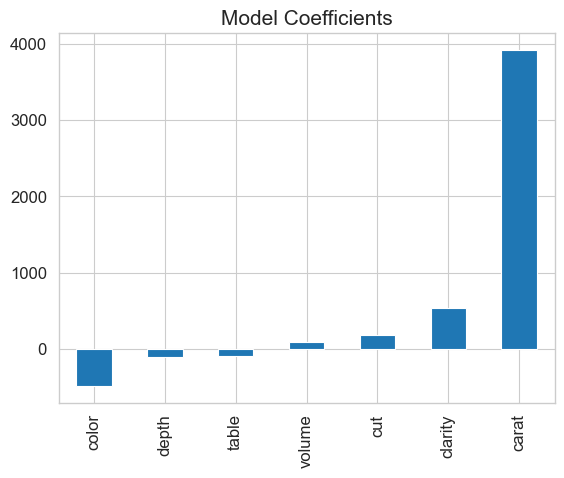

In [48]:
# Plot the coefficients in a barplot. Optionally, you can also sort them in an increasing or decreasing order

coef = pd.Series(ridge_optmodel.coef_, X_train.columns).sort_values()
coef.plot(kind='bar', title='Model Coefficients')
plt.show()

In [49]:
# Store the model performances in regr_results for the final comparison 

regr_results = pd.concat([regr_results, pd.json_normalize({'Model': 'Ridge',
                                                            'r2':   round(r2_score(y_test, y_pred_opt),3), 
                                                            'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred_opt)),3),
                                                            'MAE':  round(mean_absolute_error(y_test, y_pred_opt),3)})])

regr_results

,Model,r2,RMSE,MAE
0,Linear model (OLS),0.883,1372.015,883.58
0,Ridge,0.883,1372.015,883.58



#### 2) Regularization with Lasso Regression (L1 regularization)

Lasso regression is another type of *linear regression* that adds a penalty term to the loss function, but it encourages the model to select a subset of the independent variables that are most relevant for prediction. Lasso regression is also very similar to Ridge. There is only a minor difference in the cost function: instead of taking the square of each coefficient, Lasso regression takes the absolute values of them. The rest are practically the same.

Let's try first with a pre-defined parameter of `alpha`. The `alpha` is a hyperparameter that controls the regularization strength. It must be a positive float. The default value is 1. Larger values of `alpha` imply stronger regularization (less-overfitting, may be underfitting!). Smaller values imply weak regularization (overfitting). We want to build a model that neither overfits nor underfit the data. So, we need to choose an optimal value for `alpha`. For that, we can use a hyperparameter tuning technique. 

In [50]:
# 1) Instantiate a Lasso model with a regularization parameter alpha=0.1. Name your model "lasso"
# 2) Fit it to the training data X_train and y_train using the fit method 
# 3) Predict using the test data and calculate the performance metrics
# The alpha is a hyperparameter to tune and we need to find out the optimal alpha value

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

In [51]:
# 4) Print the performance metrics R^2, RMSE and MAE 

print("Training score:", lasso.score(X_train, y_train))
print("Testing score:",  lasso.score(X_test, y_test))
print("MAE of Lasso Regression:", mean_absolute_error(y_test, y_pred), '\n')

Training score: 0.8818305466166022
Testing score: 0.883235740655139
MAE of Lasso Regression: 883.5367730014065 



In [52]:
# Putting together the lasso coefficient and their corresponding variable names in a new DF named 'coef_lasso'

coef_lasso = pd.DataFrame({"var": X_train.columns, 
                           "coef":lasso.coef_})

#show the dataframe
coef_lasso

,var,coef
0,carat,3920.487211
1,cut,176.496974
2,color,-486.033696
3,clarity,539.992891
4,depth,-111.911254
5,table,-91.209938
6,volume,84.054005


##### Lasso with optimal alpha using Cross-Validation in Sklearn

To find the optimal value of alpha, we use scikit learns lasso linear model with iterative fitting along a regularization path (`LassoCV`). The best model is selected by cross-validation

In [53]:
# Execute tuning of alpha using LassoCV() and assign to a variable named "lassoCV_model". Pass: 
# as alpha the values of np.logspace(-6, 6, 13) 
# as scoring the value 'r2', random_state=0 
# and set cv equal to 10 for 10-fold cross-validation
# Fit lassoCV_model to your train data 
# Return the print lassoCV_model.alpha_ 

lassoCV_model = LassoCV(alphas=np.logspace(-6, 6, 13), cv=10, random_state=0) 
lassoCV_model.fit(X_train, y_train)

optimal_alpha = lassoCV_model.alpha_
print(optimal_alpha)

1e-06


Let’s finally evaluate Lasso with that hyperparameter and compare it with Linear Regression:

In [54]:
# Optimal model - implement the optimal model named "lasso_optmodel" with the new optimal alpha
# Print your final results

lasso_optmodel = Lasso(alpha = optimal_alpha)
lasso_optmodel.fit(X_train, y_train)
y_pred_opt = lasso_optmodel.predict(X_test)

print('r2 score (coefficient of determination): '+str(round(r2_score(y_test, y_pred_opt),3)))
print('RMSE : '+str(round(np.sqrt(mean_squared_error(y_test, y_pred_opt)),3)))  
print('MAE : ' +str(round(mean_absolute_error(y_test, y_pred_opt),3)))

r2 score (coefficient of determination): 0.883
RMSE : 1372.015
MAE : 883.58


We can also print the model coefficients. The lasso.coef_ attribute returns the coefficients of the features in the model. 

In [55]:
# print the model coefficients 
print('Model coefficients:', lasso_optmodel.coef_)

Model coefficients: [3920.817665    176.50659659 -486.1902122   540.13250329 -112.05233502
  -91.36503111   83.94327593]


Lasso regression did a fairly good job. One really cool thing about Lasso regression is that it can be used for feature selection. Because of how it works under the hood, Lasso regression has the ability to shrink unimportant parameters all the way down to zero. We can check this by plotting the above fitted lasso's coefficients using its coef_ attribute:

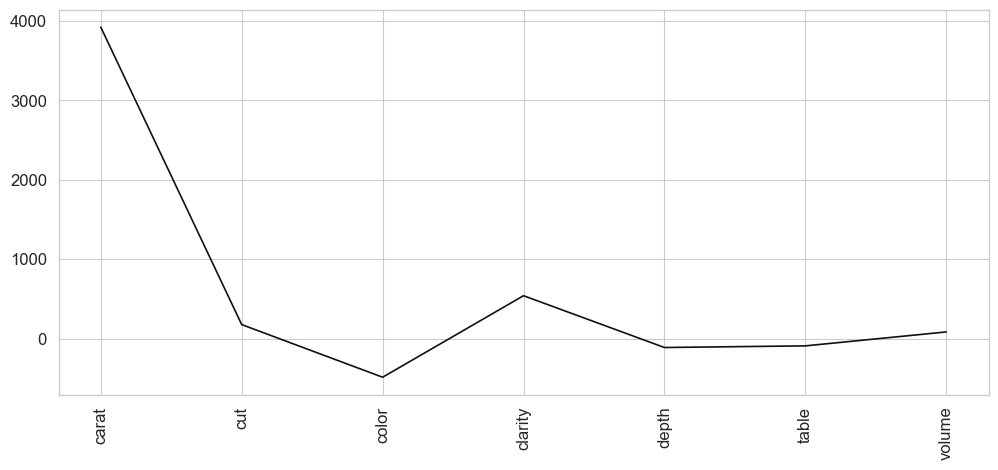

In [56]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(X_train.columns, lasso_optmodel.coef_, color='#111111')

plt.setp(ax.get_xticklabels(), rotation=90);

In [57]:
#extract the coefficients
coef_lasso = pd.DataFrame({"var": X_train.columns, 
                           "coef":lasso_optmodel.coef_})

#show the dataframe
coef_lasso

,var,coef
0,carat,3920.817665
1,cut,176.506597
2,color,-486.190212
3,clarity,540.132503
4,depth,-112.052335
5,table,-91.365031
6,volume,83.943276


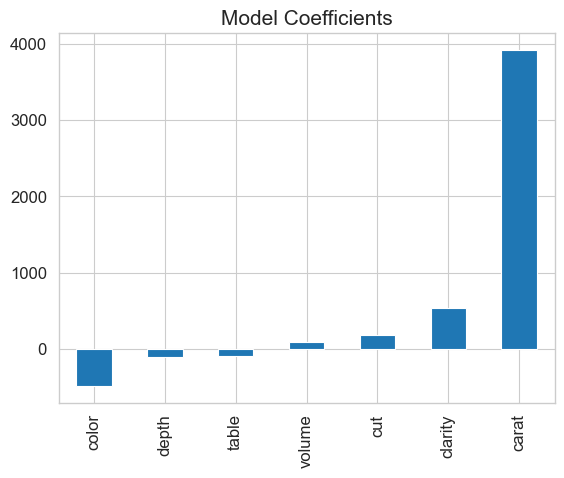

In [58]:
coef = pd.Series(lasso_optmodel.coef_, X_train.columns).sort_values()
coef.plot(kind='bar', title='Model Coefficients')
plt.show()

In [59]:
# Store the model performances in regr_results for the final comparison 

regr_results = pd.concat([regr_results, pd.json_normalize({'Model': 'Lasso',
                                                            'r2':   round(r2_score(y_test, y_pred_opt),3), 
                                                            'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred_opt)),3),
                                                            'MAE':  round(mean_absolute_error(y_test, y_pred_opt),3)})])

regr_results

,Model,r2,RMSE,MAE
0,Linear model (OLS),0.883,1372.015,883.58
0,Ridge,0.883,1372.015,883.58
0,Lasso,0.883,1372.015,883.58


### Polynomial Regression

#### Why polynomial regression? 

In a nutshell, to overcome under-fitting, we need to increase the complexity of the model. Implementing polynomial regression with scikit-learn is very similar to linear regression. There’s only one extra step: you need to transform the array of inputs to include nonlinear terms such as 𝑥².

##### Transform the input data

This is the new step that you need to implement for polynomial regression! To convert the original features into their higher order terms we will use the `PolynomialFeatures` class provided by `scikit-learn`. You can provide several optional parameters to `PolynomialFeatures`:

- `degree` is an integer (2 by default) that represents the degree of the polynomial regression function.
- `interaction_only` is a Boolean (False by default) that decides whether to include only interaction features (True) or all features (False).
- `include_bias` is a Boolean (True by default) that decides whether to include the bias, or intercept, column of 1 values (True) or not (False).

In [60]:
polynomial_features= PolynomialFeatures(degree=3)

X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly  = polynomial_features.transform(X_test)

##### Create a model and fit it 

This step is also the same as in the case of linear regression. You create and fit the model:

In [61]:
# 1) Instantiate the LinearRegression() model from sklearn. Store it into a new variable "poly_model" 
# 2) Fit poly_model to your training data  X_train_poly and y_train
# 3) Predict using only the X_test_poly set and store the results into a new variable y_pred_poly
# 4) Print the regression (prediction/evaluation) test metrics R^2, RMSE and MAE 

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)


print('r2 score (coefficient of determination): '+str(round(r2_score(y_test, y_pred_poly),3)))
print('RMSE : '+str(round(np.sqrt(mean_squared_error(y_test, y_pred_poly)),3)))  
print('MAE : ' +str(round(mean_absolute_error(y_test, y_pred_poly),3)))

r2 score (coefficient of determination): 0.941
RMSE : 977.671
MAE : 532.923


In [62]:
# Store the model performances in regr_results for the final comparison 

regr_results = pd.concat([regr_results, pd.json_normalize({'Model': 'Poly',
                                                            'r2':   round(r2_score(y_test, y_pred_poly),3), 
                                                            'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred_poly)),3),
                                                            'MAE':  round(mean_absolute_error(y_test, y_pred_poly),3)})])

regr_results

,Model,r2,RMSE,MAE
0,Linear model (OLS),0.883,1372.015,883.580
0,Ridge,0.883,1372.015,883.580
0,Lasso,0.883,1372.015,883.580
0,Poly,0.941,977.671,532.923


### Other non-linear models 

#### RandomForestRegressor

Let's try a RFR using the default parameters:

In [63]:
# 1) Instantiate a RandomForestRegressor() using random_state=0 
# 2) Fit your RF to your training data  
# 3) Predict using only the test set and store the results into a new variable y_pred
# 4) Print your metrics 

rr  = RandomForestRegressor(random_state=0)
rr.fit(X_train, y_train)
y_pred = rr.predict(X_test)

print('r2 score (coefficient of determination): '+str(round(r2_score(y_test, y_pred),3)))
print('RMSE : '+str(round(np.sqrt(mean_squared_error(y_test, y_pred)),3)))  
print('MAE : ' +str(round(mean_absolute_error(y_test, y_pred),3)))

r2 score (coefficient of determination): 0.98
RMSE : 568.918
MAE : 286.298


Tune the `RandomForestRegressor` using  `RandomizedSearchCV`

In [64]:
# Create the dictionary of parameters for the RF model 
# Tune using 5-fold cross-validation with RandomizedSearchCV(). 
# Set the iterations to 10 and n_jobs=-1 for parallelization
# Fit your RandomizedSearchCV to your training data and print the best parameters 

random_grid = {'n_estimators': [int(x) for x in np.linspace(10,200,10)],
               'max_depth': [int(x) for x in np.linspace(10,100,10)],
               'min_samples_split': [2,3,4,5,10],
               'min_samples_leaf':  [1,2,4,10,15,20]}

rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(),
                               param_distributions = random_grid,
                               n_iter=10,
                               cv = 5, 
                               n_jobs=-1)

rf_random.fit(X_train,y_train)
rf_random.best_params_

{'n_estimators': 94,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 50}

In [65]:
# Get the optimal model from the tuning process, fit it in the data, 
# predict the test data and report the final performance metrics 

rf_opt = rf_random.best_estimator_
rf_opt.fit(X_train,y_train)
y_pred_opt = rf_opt.predict(X_test)

print('r2 score (coefficient of determination): '+str(round(r2_score(y_test, y_pred_opt),3)))
print('RMSE : '+str(round(np.sqrt(mean_squared_error(y_test, y_pred_opt)),3)))  
print('MAE : ' +str(round(mean_absolute_error(y_test, y_pred_opt),3)))

r2 score (coefficient of determination): 0.98
RMSE : 566.155
MAE : 287.05


In [66]:
# Store the model performances in regr_results for the final comparison 

regr_results = pd.concat([regr_results, pd.json_normalize({'Model': 'RFRegressor',
                                                            'r2':   round(r2_score(y_test, y_pred_opt),3), 
                                                            'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred_opt)),3),
                                                            'MAE':  round(mean_absolute_error(y_test, y_pred_opt),3)})])

regr_results

,Model,r2,RMSE,MAE
0,Linear model (OLS),0.883,1372.015,883.580
0,Ridge,0.883,1372.015,883.580
0,Lasso,0.883,1372.015,883.580
0,Poly,0.941,977.671,532.923
0,RFRegressor,0.980,566.155,287.050


### Comparison

In [67]:
# Print the regr_results. Optionally, you can also sort by RMSE

regr_results.sort_values(by=['RMSE'], ascending=[True])

,Model,r2,RMSE,MAE
0,RFRegressor,0.980,566.155,287.050
0,Poly,0.941,977.671,532.923
0,Linear model (OLS),0.883,1372.015,883.580
0,Ridge,0.883,1372.015,883.580
0,Lasso,0.883,1372.015,883.580
